Median Age: 74.25


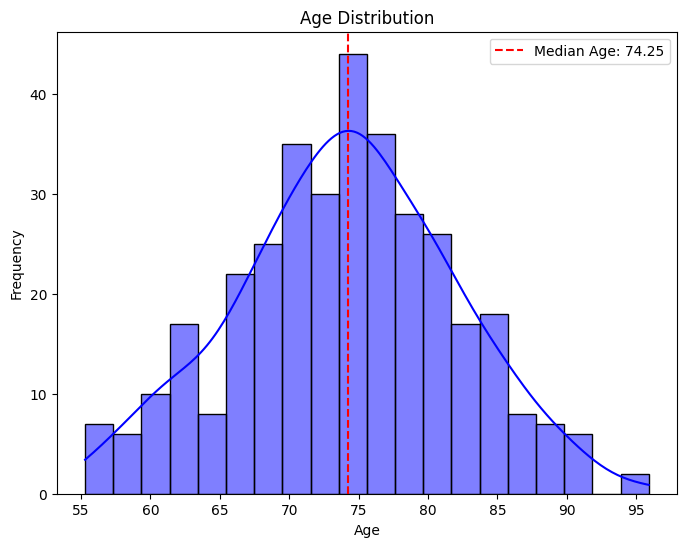

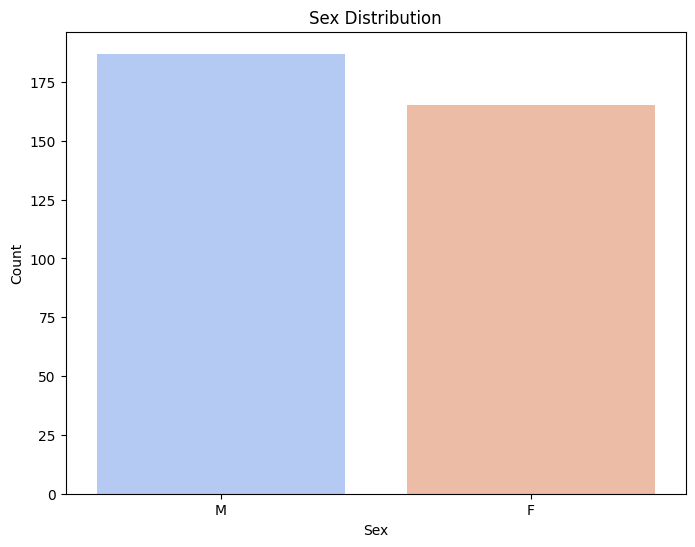

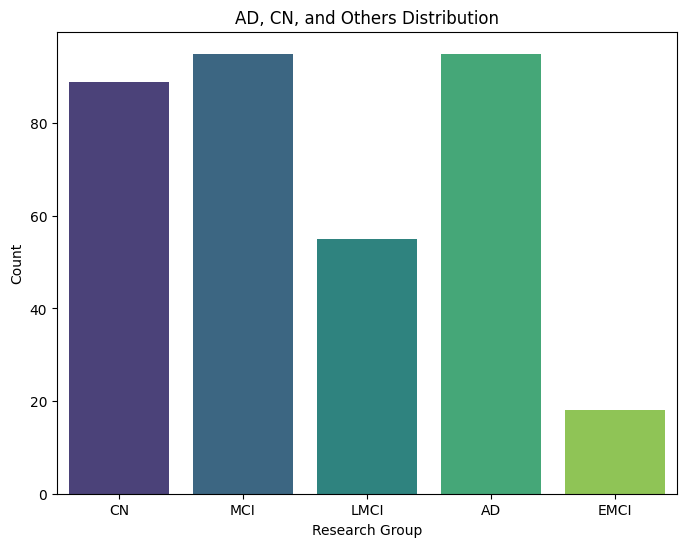

Sex             F   M
ResearchGroup        
AD             40  55
CN             52  37
EMCI            8  10
LMCI           23  32
MCI            42  53
AD_men: 55 subjects
AD_women: 40 subjects
CN_men: 37 subjects
CN_women: 52 subjects
Other_men: 95 subjects
Other_women: 73 subjects
Train set: 244 subjects
Validation set: 50 subjects
Test set: 58 subjects


In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
project_dir = '/home/santiago/Desktop/azheimer/'  # Adjust to your path
csv_path = os.path.join(project_dir, 'DataBaseSubjects.csv')
tensor_data_dir = os.path.join(project_dir, 'TensorData')

# Load the CSV file
subjects_df = pd.read_csv(csv_path)

# Calculate the median age and print it
median_age = subjects_df['Age'].median()
print(f"Median Age: {median_age}")

# Plot the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(subjects_df['Age'], bins=20, kde=True, color='blue')
plt.axvline(median_age, color='red', linestyle='--', label=f'Median Age: {median_age}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the sex distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', data=subjects_df, palette='coolwarm')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot the distribution of AD, CN, and Others
plt.figure(figsize=(8, 6))
sns.countplot(x='ResearchGroup', data=subjects_df, palette='viridis')
plt.title('AD, CN, and Others Distribution')
plt.xlabel('Research Group')
plt.ylabel('Count')
plt.show()

# Group subjects by Research Group and Sex
grouped_data = subjects_df.groupby(['ResearchGroup', 'Sex']).size().unstack().fillna(0)
print(grouped_data)

# Initialize dictionaries for storing tensor paths by group and sex
tensor_groups = {
    'AD_men': [],
    'AD_women': [],
    'CN_men': [],
    'CN_women': [],
    'Other_men': [],
    'Other_women': []
}

# Iterate over subjects and assign tensors to groups
for subject_id in subjects_df['SubjectID']:
    group = subjects_df[subjects_df['SubjectID'] == subject_id]['ResearchGroup'].values[0]
    sex = subjects_df[subjects_df['SubjectID'] == subject_id]['Sex'].values[0]
    file_name = f'{group}_tensor_{subject_id}.pt'
    file_path = os.path.join(tensor_data_dir, file_name)
    
    if os.path.exists(file_path):
        if group == 'AD':
            if sex == 'M':
                tensor_groups['AD_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['AD_women'].append(file_path)
        elif group == 'CN':
            if sex == 'M':
                tensor_groups['CN_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['CN_women'].append(file_path)
        else:  # Others
            if sex == 'M':
                tensor_groups['Other_men'].append(file_path)
            elif sex == 'F':
                tensor_groups['Other_women'].append(file_path)

# Print the number of subjects in each group
for key, value in tensor_groups.items():
    print(f'{key}: {len(value)} subjects')

# Split data into train, validation, and test sets with equal proportions
def split_data(tensors, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    np.random.shuffle(tensors)
    n_total = len(tensors)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_set = tensors[:n_train]
    val_set = tensors[n_train:n_train + n_val]
    test_set = tensors[n_train + n_val:]
    
    return train_set, val_set, test_set

# Initialize lists for train, validation, and test sets
train_set, val_set, test_set = [], [], []

# Combine groups ensuring equal proportions of gender and research groups
for group in tensor_groups:
    train, val, test = split_data(tensor_groups[group])
    train_set.extend(train)
    val_set.extend(val)
    test_set.extend(test)

# Print final counts of train, validation, and test sets
print(f"Train set: {len(train_set)} subjects")
print(f"Validation set: {len(val_set)} subjects")
print(f"Test set: {len(test_set)} subjects")




In [9]:
# Load the tensors and create datasets
def load_tensors(file_paths):
    tensors = []
    for fp in file_paths:
        data = torch.load(fp)
        if isinstance(data, np.ndarray):  # Convert numpy arrays to tensors
            data = torch.tensor(data)
        tensors.append(data)
    return torch.stack(tensors)

# Load data for train, validation, and test sets
train_data = load_tensors(train_set)
val_data = load_tensors(val_set)
test_data = load_tensors(test_set)

print("Datasets have been constructed with equal proportions.")


Datasets have been constructed with equal proportions.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the 3D Convolutional VAE
class Conv3DVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(Conv3DVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=2, padding=1),  # (B, 32, 58, 58, 58)
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, 29, 29, 29)
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 15, 15, 15)
            nn.ReLU()
        )
        
        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 15 * 15 * 15, latent_dim)
        self.fc_logvar = nn.Linear(128 * 15 * 15 * 15, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 15 * 15 * 15)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 29, 29, 29)
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 58, 58, 58)
            nn.ReLU(),
            nn.ConvTranspose3d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, 116, 116, 116)
            nn.Sigmoid()  # Output normalized to [0, 1]
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(h.size(0), 128, 15, 15, 15)  # Reshape for 3D deconv
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

# Loss function (Reconstruction + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Training function
def train_vae(model, train_loader, val_loader, epochs=50, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    best_val_loss = np.inf
    early_stop_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # Training loop
        for data in train_loader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        # Average training loss
        train_loss /= len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                recon_batch, mu, logvar = model(data)
                loss = vae_loss(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        # Average validation loss
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_vae_model.pth')
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

# Example data loaders (assuming you have loaded train, val, and test datasets as tensors)
batch_size = 16
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size)

# Initialize and train the VAE model
vae_model = Conv3DVAE(latent_dim=64).to('cuda')  # Assuming you're using a GPU
train_vae(vae_model, train_loader, val_loader, epochs=50, patience=5)

# After training, load the best model for inference or further evaluation
vae_model.load_state_dict(torch.load('best_vae_model.pth'))
print("Model training complete.")


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx